<a href="https://colab.research.google.com/github/Brian-ovita/Brian-ovita/blob/main/TextClassificationUsingTensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [18]:
df = pd.read_csv("wine-reviews.csv",usecols = ['country','description','points','price','variety','winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [19]:
df = df.dropna(subset=['description','points'])

In [20]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


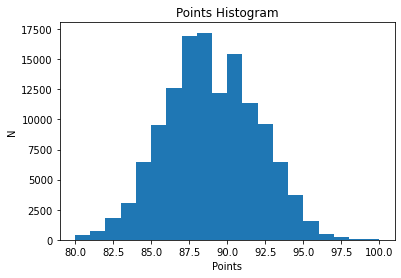

In [21]:
plt.hist(df.points,bins=20)
plt.title("Points Histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [22]:
##Create a binary label for the points column
df["label"] = (df.points >= 90).astype(int)

## Columns to be used
df = df[['description','label']]

In [23]:
## slitting the data
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)),int(0.9*len(df))])

In [24]:
## check the lengths of train, val, test
len(train), len(val), len(test)

(103976, 12997, 12998)

In [25]:
## from tensorflow 
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [26]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

Embedding and Model

In [28]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [29]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.4485366 , -0.12048443, -0.20678338, ..., -0.05102262,
        -0.10443728,  0.08925461],
       [ 0.5200426 , -0.13741674,  0.04655821, ..., -0.08949349,
        -0.17492342, -0.0874854 ],
       [ 0.34638748, -0.02503181,  0.07693952, ...,  0.08102351,
        -0.34630308, -0.00616687],
       ...,
       [ 0.3613399 , -0.25668254,  0.05665551, ..., -0.11919702,
         0.01316306, -0.09442299],
       [ 0.38653716, -0.23068711,  0.15664427, ..., -0.08515253,
        -0.01547788,  0.1926365 ],
       [ 0.3399865 , -0.09816758,  0.01165826, ..., -0.04550866,
        -0.18846592, -0.05813891]], dtype=float32)>

In [38]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryFocalCrossentropy(),
              metrics=['accuracy'])

In [40]:
model.evaluate(train_data)

102/102 [==============================] - 10s 88ms/step - loss: 0.1841 - accuracy: 0.4595


[0.18407823145389557, 0.45948103070259094]

In [41]:
model.evaluate(valid_data)

13/13 [==============================] - 1s 95ms/step - loss: 0.1840 - accuracy: 0.4603


[0.18401215970516205, 0.4602600634098053]

In [42]:
history = model.fit(train_data, epochs=5, validation_data= valid_data)

Epoch 1/5
102/102 [==============================] - 66s 632ms/step - loss: 0.1479 - accuracy: 0.6774 - val_loss: 0.1097 - val_accuracy: 0.8071
Epoch 2/5
102/102 [==============================] - 67s 652ms/step - loss: 0.1021 - accuracy: 0.8260 - val_loss: 0.1008 - val_accuracy: 0.8260
Epoch 3/5
102/102 [==============================] - 68s 662ms/step - loss: 0.0863 - accuracy: 0.8590 - val_loss: 0.1014 - val_accuracy: 0.8237
Epoch 4/5
102/102 [==============================] - 62s 605ms/step - loss: 0.0802 - accuracy: 0.8726 - val_loss: 0.1068 - val_accuracy: 0.8243
Epoch 5/5
102/102 [==============================] - 67s 658ms/step - loss: 0.0754 - accuracy: 0.8803 - val_loss: 0.1128 - val_accuracy: 0.8262


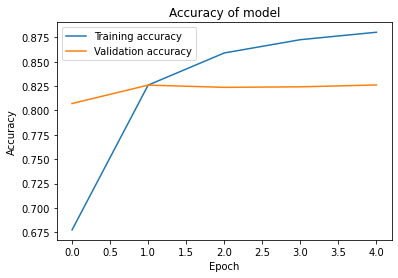

In [43]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

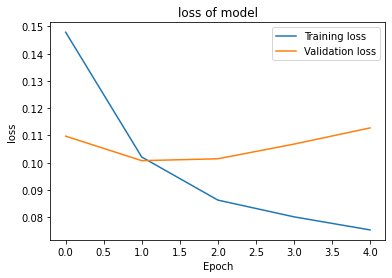

In [44]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('loss of model')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()